# In this note book we will analyze the transeverse field Ising model (TFIM) by using ED and QAOA

The many-body spin Hamiltnonian in 1-d is given by:

$$ \mathcal{H}= -(1-t)\sum_{i}\sigma^z_i\sigma^z_{i+1}-t\sum_i \sigma^x_i $$

This is an exactly solvable model, the sollution can be found in the second chapter of <a href="https://arxiv.org/pdf/0904.2771.pdf">this lecture note</a>.

For the limit $t=0$, this has a ferromagnetic (FM) ground state (GS) with two fold degeneracy, which spontaneously breaks the global $Z_2$ symmetry of the Hamiltonian. In the limit $t=1$, the GS is unique (called paramagetic, i.e. PM) and doesn't break any symmetry.

In this notebook we will do the following things:

* <a href='#ed'>Solve it using ED</a>
* <a href='#qaoa'>Solve it using QAOA</a>
* <a href='#compare'>Comapre the results</a>
* <a href='#expect_value'>Magnetization and the correlations.</a>

# Exact diagonalization <a id='ed'></a>

In [1]:
# basic python operations
import numpy as np

# scientific coputing
from functools import reduce
import scipy.sparse as sps
import scipy.sparse.linalg as spslin
from scipy.optimize import curve_fit

# visualization
import matplotlib.pyplot as plt

# Loading the Pauli matrices

Id = sps.eye(2)
Sx = sps.csr_matrix(np.array([[0,1.+0.j],[1+0.j,0]]))
Sy = sps.csr_matrix(np.array([[0,-1.j],[1.j,0]]))
Sz = sps.csr_matrix(np.array([[1+0.j,0.],[0,-1+0.j]]))

### Building the many-body Hamiltonian

In [2]:
def ham_general(L,static):
    ham_gen=np.zeros(shape=(2**L,2**L),dtype=np.complex)
    for item in static:
        string=item[0]
        for inside in item[1:len(item)]:
            for j in range(len(inside)):
                op_list=[Id]*L
                for k in range(len(string)):
                    if string[k]=='x':
                        op_list[inside[j][k+1]]=Sx
                    elif string[k]=='y':
                        op_list[inside[j][k+1]]=Sy
                    elif string[k]=='z':
                        op_list[inside[j][k+1]]=Sz
                #print(reduce(sps.kron,op_list).toarray())
                ham_gen += inside[j][0]*reduce(sps.kron,op_list).toarray()
    #            
    return ham_gen

### System size (SS): L=6

In [3]:
L=6
t_arr=np.linspace(0,1,21)
evalu=8

energy_ed=np.ndarray(shape=(len(t_arr),evalu))
gs_vec=np.ndarray(shape=(2**L,len(t_arr)),dtype=np.complex)

for j in range(len(t_arr)):
    ## defining the parameter
    g=t_arr[j]
    J=(1-t_arr[j])
    ## making the adjacent matrix
    x_field=[[-g,i] for i in range(L)]
    J_nn=[[-J,i,(i+1)%L] for i in range(L)]
    static=[["zz",J_nn],["x",x_field]]
    ## diagonalization of the Hamiltonian
    hamiltonian=ham_general(L,static)
    (e2,u) = spslin.eigsh(hamiltonian, k=evalu, which='SA',return_eigenvectors=True)
    energy_ed[j,:]=np.sort(e2)
    gs_vec[:,j]=u[:,0]

# Solving the problem with QAOA <a id='qaoa'></a>

QAOA method is a <a href='https://arxiv.org/abs/1411.4028'>variational method</a>, which is in turn inspired by the <a href='https://arxiv.org/abs/quant-ph/0001106'>adiabatic quantum computation</a>. We alternatively apply rotation with respect to the Hamiltonoan (any) and a mixer term (uniform x-field) with the angles $\gamma$ and $\beta$ respectively. After computing the energy of the final state at the end of the rotation, using the Hamiltonian, we get 

$$F(\overrightarrow{\beta},\overrightarrow{\gamma})\equiv<\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}|\mathcal{H}|\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}>$$

With $|\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}> =  \left(e^{-i\beta_p B}e^{-i\gamma_p H}\right)\cdots \left(e^{-i\beta_1 B}e^{-i\gamma_1 C}\right) H^{\otimes n} |0>$. Next we optimize the rotation angle so that the energy of the final state is minimized, and we get a optimal set of $(\overrightarrow{\beta}^*,\overrightarrow{\gamma}^*)$, and the supposedly GS of the system. Since the optimization is done in a classical computer, while the rotation is performed in quantum computer, this is called hybrid solver, which is claimed to be useful for the current noisy quantum computers available today. Thus the current era of quantum computing is called the era of <a href='https://quantum-journal.org/papers/q-2018-08-06-79/'>noisy intermediate-scale quantum (NISQ)</a> computing.

The claim is if we increase this alternate layer, we get more closer to the GS.

This is the full circuit, with we will now choose, $p=1~;~\beta=\text{x-field angle} (B);~\gamma=\text{Hamiltonian angle}(\mathcal{H})$


<img src="./qaoa.jpeg" width="700" height="700">


In [4]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.3', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [5]:
# to set up the problem
import networkx as nx

# for classical optimization
from scipy.optimize import minimize

# for quantum computataion
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram

## Creating the graph

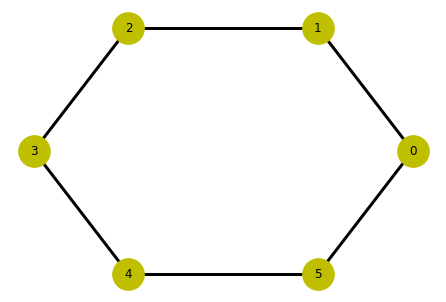

In [6]:
G = nx.Graph()
G.add_nodes_from([i for i in range(L)])
G.add_edges_from([[i,i+1] for i in range(L-1)])
G.add_edges_from([[L-1,0]])
options = {
    'node_color': 'y',
    'node_size': 1000,
    'width': 3,
}
nx.draw(G, with_labels=True,pos=nx.circular_layout(G),**options)

In [7]:
print(list(G.edges()))
print(G.number_of_nodes())

[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]
6


## Defining the rotation circuit corresponding to the Hamiltonian

Bellow we define the rotation Hamiltonian in a quantum circuit

In [8]:
def ham_rot(G,gamma):
    L=G.number_of_nodes()
    qc=QuantumCircuit(L,L)
    for i,j in list(G.edges()):
        qc.cx(i,j)
        qc.rz(2*gamma,j)
        qc.cx(i,j)
    for n in G.nodes():
        qc.rx(2*gamma, n)
    return qc

In [9]:
qc = ham_rot(G, np.pi/3)
print(G.edges())
qc.draw()

[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]


┌──────────┐»
q_0: ──■────────────────■────■────────────────────────────■──┤ RX(2π/3) ├»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                            │  └──────────┘»
q_1: ┤ X ├┤ RZ(2π/3) ├┤ X ├──┼───────■────────────────────┼───────■──────»
     └───┘└──────────┘└───┘  │     ┌─┴─┐    ┌──────────┐  │     ┌─┴─┐    »
q_2: ────────────────────────┼─────┤ X ├────┤ RZ(2π/3) ├──┼─────┤ X ├────»
                             │     └───┘    └──────────┘  │     └───┘    »
q_3: ────────────────────────┼────────────────────────────┼──────────────»
                             │                            │              »
q_4: ────────────────────────┼────────────────────────────┼──────────────»
                           ┌─┴─┐┌──────────┐            ┌─┴─┐            »
q_5: ──────────────────────┤ X ├┤ RZ(2π/3) ├────────────┤ X ├────────────»
                           └───┘└──────────┘            └───┘            »
c: 6/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌──────────┐                                                          »
«q_1: ┤ RX(2π/3) ├──────────────────────────────────────────────────────────»
«     └──────────┘                 ┌──────────┐                             »
«q_2: ─────■────────────────────■──┤ RX(2π/3) ├─────────────────────────────»
«        ┌─┴─┐    ┌──────────┐┌─┴─┐└──────────┘                 ┌──────────┐»
«q_3: ───┤ X ├────┤ RZ(2π/3) ├┤ X ├─────■────────────────────■──┤ RX(2π/3) ├»
«        └───┘    └──────────┘└───┘   ┌─┴─┐    ┌──────────┐┌─┴─┐└──────────┘»
«q_4: ────────────────────────────────┤ X ├────┤ RZ(2π/3) ├┤ X ├─────■──────»
«                                     └───┘    └──────────┘└───┘   ┌─┴─┐    »
«q_5: ─────────────────────────────────────────────────────────────┤ X ├────»
«                                                                  └───┘    »
«c: 6/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                  
«q_0: ─────────────────────────────
«                                  
«q_1: ─────────────────────────────
«                                  
«q_2: ─────────────────────────────
«                                  
«q_3: ─────────────────────────────
«                      ┌──────────┐
«q_4: ──────────────■──┤ RX(2π/3) ├
«     ┌──────────┐┌─┴─┐├──────────┤
«q_5: ┤ RZ(2π/3) ├┤ X ├┤ RX(2π/3) ├
«     └──────────┘└───┘└──────────┘
«c: 6/═════════════════════════════
«

In [10]:
def x_field_rot(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        qc.rx(2*beta, n)
    return qc

In [11]:
qc = x_field_rot(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ RX(2π/3) ├
     ├──────────┤
q_1: ┤ RX(2π/3) ├
     ├──────────┤
q_2: ┤ RX(2π/3) ├
     ├──────────┤
q_3: ┤ RX(2π/3) ├
     ├──────────┤
q_4: ┤ RX(2π/3) ├
     ├──────────┤
q_5: ┤ RX(2π/3) ├
     └──────────┘
c: 6/════════════

### Defining the QAOA circuit

In [12]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(G,gamma[k])
        qc=qc+x_field_rot(G,beta[k])
    # no measurement in the end!
    return qc

In [13]:
def compute_ising_energy_sv(sv_old,hamilton):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    sv=np.flip(sv_old)
    #sv=np.array(sv_old)
    adjsv=np.conjugate(sv)
    mult=np.matmul(hamilton, sv)
    ener=np.matmul(adjsv,mult)
    return ener.real

In [14]:
def get_black_box_objective_sv(G, p, hamilton, energy_sv):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G,beta, gamma)
        sv = execute(qc, backend).result().get_statevector()  # the sv is np.array with complex entries
        # return the energy
        ener=compute_ising_energy_sv(sv, hamilton)
        energy_sv.append(ener)
        return ener, energy_sv
    return f

In [15]:
# we are choosing p number of layers

p=8
angle_arr=np.ndarray(shape=(len(t_arr),2*p))
gs_energy_qaoa=np.ndarray(shape=(len(t_arr),))
n_iter=np.ndarray(shape=(len(t_arr),))

for j in range(len(t_arr)):
    energy_sv=[]
    np.random.seed(123)
    init_point = np.random.rand(2*p)
    # define Hamiltonian
    g=t_arr[j]
    J=(1-t_arr[j])
    ## making the adjacent matrix
    x_field=[[-g,i] for i in range(L)]
    J_nn=[[-J,i,(i+1)%L] for i in range(L)]
    static=[["zz",J_nn],["x",x_field]]
    hamiltonian=ham_general(L,static)
    obj = get_black_box_objective_sv(G, p, hamiltonian,energy_sv)
    # We are going to limit the number of iterations to 2500
    res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': False})
    angle_arr[j,:]=res_sv['x']
    gs_energy_qaoa[j]=res_sv['fun']
    n_iter[j]=res_sv['nfev']

/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  # Remove the CWD from sys.path while we load stuff.
/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [16]:
gs_energy_qaoa,n_iter

(array([-5.99999749, -5.70393983, -5.41667129, -5.13978302, -4.87534144,
        -4.62612836, -4.39616219, -4.19162725, -4.02277284, -3.90631713,
        -3.86370077, -3.90630706, -4.02277377, -4.19162994, -4.39615888,
        -4.62613143, -4.8753406 , -5.13978866, -5.41665853, -5.70394774,
        -5.9999978 ]),
 array([496., 553., 523., 572., 544., 587., 312., 519., 542., 595., 689.,
        738., 959., 638., 432., 508., 372., 351., 423., 288., 372.]))

# Comparing the results <a id='compare'></a>

We will now compare the results from the two methods, by looking at the GS energy and the overlap between the GS obtained in different methods.

Run the circuit for one more time for each values of $t$ with the optimal theta.

In [17]:
new_sv=np.ndarray(shape=(2**L,len(t_arr)),dtype=np.complex)

for j in range(len(t_arr)):
    optimal_theta = angle_arr[j,:]
    qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
    backend = Aer.get_backend('statevector_simulator')
    new_sv[:,j] = execute(qc, backend).result().get_statevector()

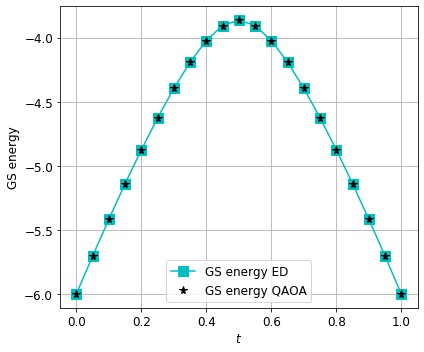

In [18]:
ms,fs=8,12

plt.figure(figsize=(6,5))
# plt.ylim(-0.2,4.2)

plt.plot(t_arr,energy_ed[:,0],'cs-',markersize=ms+2,label='GS energy ED')
plt.plot(t_arr,gs_energy_qaoa,'k*',markersize=ms,label='GS energy QAOA')

plt.xlabel('$t$',fontsize=fs)
plt.ylabel('GS energy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

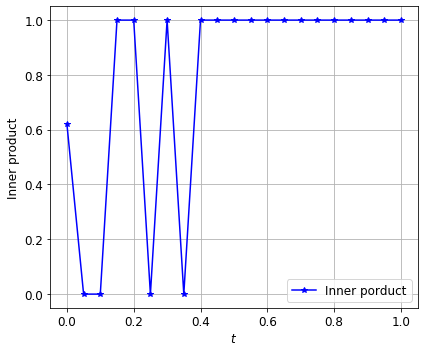

In [19]:
fidelity=np.ndarray(shape=(len(t_arr),))

for j in range(len(t_arr)):
    fidelity[j]=abs(np.matmul(np.conjugate(new_sv[:,j]),gs_vec[:,j]))
    
# plotting the data
ms,fs=6,12

plt.figure(figsize=(6,5))

plt.plot(t_arr,fidelity,'b*-',markersize=ms,label='Inner porduct')

plt.xlabel('$t$',fontsize=fs)
plt.ylabel('Inner product',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

We see that although the ground state enrgy computed using both the methods mathes pretty well, however the fidelity or the inner product between the GS vectors sometimes are orthogonal to each other, while matching perfectly most of the time.

This disagreement can be attributed to reasons 

* First, it could be due to <a href='https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.18.1049'>Anderson's orthogonalty catastrophe</a>, which says that in the increasing system size, the GS of two Hamiltonians with a arbitraryly small perturbation decreases with the increasing system size, and becomes zero in the infinite system size.

* Second, we know that in the FM case there are two fold degenerate GS which are orthogonal to each other. It could well be the two different GS are chosen by two methods, that's why we are getting a zero overlap.

Next we will look at the magnetization and the $\sigma_z$ correlation function as distance to characterize the phases.

# Calculating expectation values <a id='expect_value'></a>

### Magnetization calculated for both statevector

Magnetization is defined as:

$$ m(x)=\frac{1}{L}\sum_{i}\langle\sigma^x_i \rangle $$, where $\langle.\rangle$ denote the ground state expectation value.

In [20]:
# definging the magnetization operator

x_field=[[1./L,i] for i in range(L)]
static=[["x",x_field]]
hamiltonian=ham_general(L,static)

magnet_ed=np.ndarray(shape=(len(t_arr),))
magnet_qaoa=np.ndarray(shape=(len(t_arr),))

for j in range(len(t_arr)):
    vec_ed = np.array(gs_vec[:,j])
    vec_qaoa = np.array(new_sv[:,j])
    magnet_ed[j] = np.matmul(np.conjugate(vec_ed),np.matmul(hamiltonian,vec_ed)).real
    magnet_qaoa[j] = np.matmul(np.conjugate(vec_qaoa),np.matmul(hamiltonian,vec_qaoa)).real

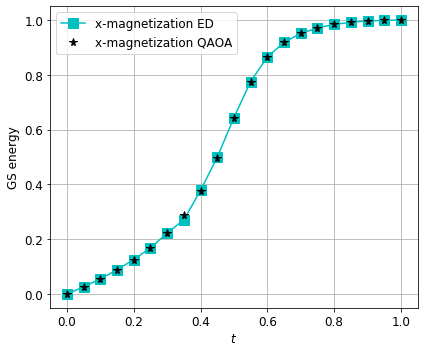

In [21]:
ms,fs=8,12

plt.figure(figsize=(6,5))
# plt.ylim(-0.2,4.2)

plt.plot(t_arr,magnet_ed,'cs-',markersize=ms+2,label='x-magnetization ED')
plt.plot(t_arr,magnet_qaoa,'k*',markersize=ms,label='x-magnetization QAOA')

plt.xlabel('$t$',fontsize=fs)
plt.ylabel('GS energy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

## $\langle\sigma^z\sigma^z\rangle $ Correlation function

The correlator function is defined as 

$$ C(r)=\frac{1}{L}\langle \sum_{i}\sigma^z_{i}\sigma^z_{i+r}\rangle $$

Sometime, the self correlator is subtracted, thus the $C(r)$ becomes a connected correlator, but here we will use the above definition.

In [22]:
t_arr_new=t_arr[0:len(t_arr):2]
corr_ed=np.ndarray(shape=(len(t_arr_new), len(range(0,L+1))))
corr_qaoa=np.ndarray(shape=(len(t_arr_new), len(range(0,L+1))))

# setting the self correlator as 1
corr_ed[:,0]=1.
corr_qaoa[:,0]=1.
#
corr_ed[:,-1]=1.
corr_qaoa[:,-1]=1.

s=np.arange(L)

for k in range(1,L):
    Txk=(s+k)%L
    zz_cor=[[1./L,i,Txk[i]] for i in range(L)]
    static=[["zz",zz_cor]]
    hamiltonian=ham_general(L,static)
    for j in range(len(t_arr_new)):
        vec_ed = np.array(gs_vec[:,j*2])
        vec_qaoa = np.array(new_sv[:,j*2])
        corr_ed[j,k] = np.matmul(np.conjugate(vec_ed),np.matmul(hamiltonian,vec_ed)).real
        corr_qaoa[j,k] = np.matmul(np.conjugate(vec_qaoa),np.matmul(hamiltonian,vec_qaoa)).real

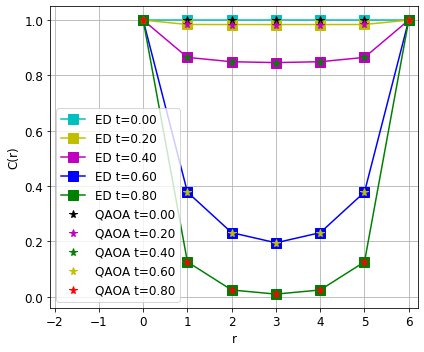

In [23]:
r=[i for i in range(L+1)]

ms,fs=8,12

plt.figure(figsize=(6,5))
plt.xlim(-2.1,6.2)

color1=['c','y','m','b','g']
color2=['k','m','g','y','r']

for j in range(0,10,2):
    plt.plot(r,corr_ed[j,:],'%ss-'%(color1[j//2]),markersize=ms+2,label='ED t=%.2f'%(t_arr_new[j]))
    
for j in range(0,10,2):
    plt.plot(r,corr_ed[j,:],'%s*'%(color2[j//2]),markersize=ms,label='QAOA t=%.2f'%(t_arr_new[j]))

plt.xlabel('r',fontsize=fs)
plt.ylabel('C(r)',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

To conclude, we see that the $\sigma^x$-magnetization and the $\sigma^z\sigma^z$-correlation are in a very good egreement for the two different methods, although there was a initial disagreement in the overlap in the GS vector. Using this result we can say confidently, QAOA is powerfull algorithm to solve complex problems in the next generations of the quantum computers.

In passing we should note that, ED is a very bad method, since it is severely limited by the system size. There are many more methods to slove a quantum system in a classical computers, such as tensor netwok or quantum monte carlo, using which we can increase the system size 10-20 times of the ED. But the QAOA method can be usefull when we get a big enough quantum computer.

One immediate drawback of the QAOA method is, it can't calculate the excited states (may be it can, but I am not aware of it). Another interesting question: is there a relation between the no of qubits and the circuit depth (`p`), we will explore these questions later

${\color{red}{\bf [total~runtime: 34 mins]}}$